In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import math

In [2]:
# Collecting a subset of 20,000 images to train, calibrate and test
# Shuffling the dataset to remove patterns/groups of related images
import random
random.seed(10) # comment out later
img_index = [i for i in range(20000)]
random.shuffle(img_index)


In [3]:
# Storing attributes Smiling, Male, Young.. for each image
import pandas as pd
df = pd.read_csv('list_attr_celeba.txt', skiprows=1, header=0, sep='\s+')

img_df = df[["Smiling", "Male", "Young", "Blond_Hair"]].head(20000)

In [4]:
# Feature extraction
def extract_features():
    """
    Extracts features from images using a pre-trained Vision Transformer (ViT)
    and saves them to a file.
    """
    EMBEDDINGS_FILE = 'embeddings.npy'
    IMAGE_DIR = 'celeba_selection'
    NUM_IMAGES_TO_PROCESS = 20000 #later change to SAMPLE_SIZE
    random.seed(10) # comment out later, for reproducibility

    if os.path.exists(EMBEDDINGS_FILE):
        print(f"Embeddings file ’{EMBEDDINGS_FILE}’ already exists. Skipping feature extraction.")
        return
    print("Starting feature extraction with Vision Transformer...")

    # 1. Load pre-trained Vision Transformer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval() # Set model to evaluation mode

    # 2. Define preprocessing steps consistent with ImageNet training
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 3. Get the list of images to process

    image_list = sorted(os.listdir(IMAGE_DIR))[:NUM_IMAGES_TO_PROCESS]
    all_features = []

    # 4. Extract embeddings for each image
    with torch.no_grad():
        for fname in tqdm(image_list, desc="Extracting ViT Embeddings"):
            img = Image.open(os.path.join(IMAGE_DIR, fname)).convert("RGB")
            x = preprocess(img).unsqueeze(0).to(device)
            # Manually replicate the forward pass to get the features before the
            # classification head, as the internal API (like .process_input)
            # can change.
            # 1. Process input using the private _process_input method
            x_processed = vit._process_input(x)
            n = x_processed.shape[0]
            # 2. Add the class token
            batch_class_token = vit.class_token.expand(n, -1, -1)
            x_with_token = torch.cat([batch_class_token, x_processed], dim=1)
            # 3. Pass through the encoder
            encoded_features = vit.encoder(x_with_token)
            # 4. Get the class token’s output (this is the feature vector)
            features = encoded_features[:, 0]
            all_features.append(features.cpu().numpy().flatten())
    all_features_np = np.array(all_features)
    print(f"Feature matrix shape: {all_features_np.shape}")
    
    # 5. Save embeddings for later use
    np.save(EMBEDDINGS_FILE, all_features_np)
    print(f"Embeddings saved to ’{EMBEDDINGS_FILE}’.")

extract_features()



Embeddings file ’embeddings.npy’ already exists. Skipping feature extraction.


In [5]:
# Partitioning the data into training/calibration/test data
embeddings = np.load("embeddings.npy")

SAMPLE_SIZE = 20000

TRAIN_RATIO = 0.7
CALIBRATION_RATIO = 0.15
TEST_RATIO = 0.15

train_index = int(TRAIN_RATIO * SAMPLE_SIZE)
calibration_index = train_index + int(CALIBRATION_RATIO * SAMPLE_SIZE)

# note - shuffle with labels later
train_embed, calibration_embed, test_embed = np.split(embeddings, [train_index, calibration_index]) 
train_labels = img_df.iloc[:train_index]
calibration_labels = img_df.iloc[train_index:calibration_index]
test_labels = img_df.iloc[calibration_index:]

In [34]:
# Modelling the Naive Bayes Model
train_embed_df = pd.DataFrame(train_embed)

def calc_mean_sd(label):
    temp_df = train_embed_df.copy()
    temp_df['label'] = train_labels[label].values

    dict_mean_sd = {}

    for c in [-1, 1]:
        feature_class = temp_df[temp_df['label'] == c].iloc[:, :-1]
        means, sds = feature_class.mean().values, feature_class.std().values
        dict_mean_sd[c] = [means, sds]

    return dict_mean_sd

stats = calc_mean_sd("Smiling")

# We model each feature (conditioned on label) under a gaussian distribution
def pd_gaussian(x, mean, sd):  
    var = math.pow(sd,2)
    exponent = -((math.pow(x - mean, 2)) / (2 * var))
    return (1 / math.sqrt(2 * math.pi * var)) * math.exp(exponent)


def naive_bayes_class(feature, label):
    # calc bayes prob for both classes of label
    # compare both
    pos = naive_bayes(feature, label, 1)
    neg = naive_bayes(feature, label, -1)
    classification = 1 if pos > neg else 0
    return classification


def naive_bayes(feature, label, label_class):
    return  likelihood(feature, label, label_class) + prior(label, label_class)


# Returns probability a sample is given a particular label/class 
def prior(label, label_class):
    label_count = train_labels[label].value_counts()[label_class]
    return math.log(label_count/len(train_labels))


# Returns conditional probability a feature is present given a label and class
def likelihood(feature, label, label_class):  
    likelihood_total = 0
    means = stats[label_class][0]
    sds = stats[label_class][1]

    for i in range(len(feature)):
        likelihood_total += math.log(pd_gaussian(feature[i], means[i], sds[i]))

    return likelihood_total

In [ ]:
# Calculating accuracy for smiling

""" 
    label - string
    ground_truth - pandas series
    set - numpy array
"""
def accuracy(label, ground_truth, samples):
    ground_truth = ground_truth["Smiling"].replace(-1, 0)
    correct_pred = 0
    for i in range(len(samples)):
        pred = naive_bayes_class(set[i], label)
        if pred == ground_truth.iloc[i]:
            correct_pred += 1

    accuracy = correct_pred / len(samples)
    return accuracy

# Test accuracy
print(accuracy("Smiling", test_labels, test_embed))

0.6903333333333334


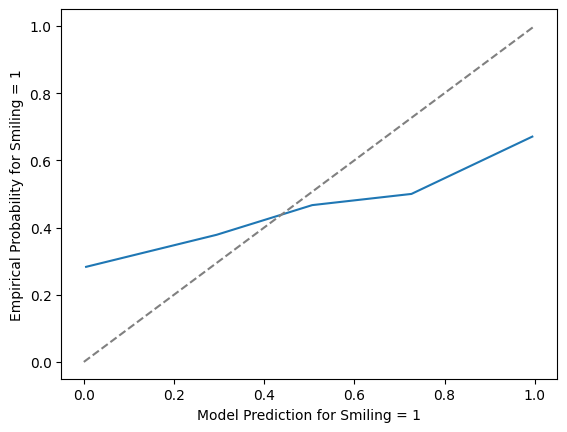

In [ ]:
# Part B - Population Calibration

# Calculate probabilities of calibration set
from scipy.special import softmax
import matplotlib.pyplot as plt

NUM_BINS = 5


def compute_calibration(calibration_data, ground_truth, label, label_class):
    pred_probabilities = compute_pred_probabilities(calibration_data, label, label_class)

    # replace -1 with 0 in label column for easier counting
    feature_labels = ground_truth[label].replace(-1, 0)

    pred_mean_probabilites, emp_mean_probabilites = compute_bin_means(pred_probabilities, feature_labels)

    return pred_mean_probabilites, emp_mean_probabilites


def compute_bin_means(pred_probabilities, feature_labels):
    bins, bin_indices = bin_data(pred_probabilities)

    pred_mean_probabilites = []
    emp_mean_probabilites = []

    for i in range(1, len(bins)):
        # collect the (indices) samples put in each bin
        sample_indices = np.where(bin_indices == i)[0]

        if len(sample_indices) == 0:
            continue

        # get the mean of samples in each bin (x-axis)
        bin_probabilities = pred_probabilities[sample_indices]
        pred_mean_probabilites.append(bin_probabilities.mean())

        # collect the corresponding samples and count how many are smiling
        # take the mean of this (y-axis) (just take mean of series as only 1s and 0s)
        bin_labels = feature_labels.iloc[sample_indices]
        emp_mean_probabilites.append(bin_labels.mean())

    return pred_mean_probabilites, emp_mean_probabilites


# computes predicted probabilities for a particular label and class (normalises probabilities)
def compute_pred_probabilities(features, label, label_class):
    pred_probabilities = []

    for feature in calibration_embed:
        log_prob_false = naive_bayes(feature, label, -1)
        log_prob_true = naive_bayes(feature, label, 1)
        log_probs = np.array([log_prob_false, log_prob_true])

        # run softmax for normalisation
        prob = softmax(log_probs)[label_class]
        pred_probabilities.append(prob)

    return np.array(pred_probabilities)


# puts data into bins and returns the list of bins of which each value was assigned
def bin_data(values):
    bins = np.linspace(0, 1, NUM_BINS+1)
    bin_indices = np.digitize(values, bins, right=True)
    return bins, bin_indices


def plot_reliability_graph(model_pred, empirical_prob, feature, class_label):
    plt.plot(model_pred, empirical_prob, label='Model calibration')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("Model Prediction for " + feature + " = " + str(class_label))
    plt.ylabel("Empirical Probability for " + feature + " = " + str(class_label))
    plt.show()

pred, emp = compute_calibration(calibration_embed, calibration_labels, "Smiling", 1)
plot_reliability_graph(pred, emp, "Smiling", 1)



In [85]:
# Computing ECE and MSE

# ECE
"""
for each bin:
- calculate the difference between mean bin probability and mean of actual positives
- multiply by the probability the model returns that 'mean bin probability'
- Sum for all bins
"""

def compute_ece(pred_probabilities, emp_probabilities, bin_counts, total_labels):
    pred_probabilities = np.array(pred_probabilities)
    emp_probabilities = np.array(emp_probabilities)

    bin_error = abs(pred_probabilities - emp_probabilities)
    ece = sum(bin_error * (bin_counts/total_labels))
    return ece


def compute_mse(ground_truth, label, data, pred_prob):
    ground_truth = ground_truth[label].replace(-1, 0).to_numpy()
    mse = 1/len(data) * (np.sum(np.power((pred_prob - ground_truth), 2)))
    return mse

pred_probabilities = compute_pred_probabilities(calibration_embed, "Smiling", 1)
bins, bin_indices = bin_data(pred_probabilities)
bin_counts = np.bincount(bin_indices - 1, minlength=len(bins)-1)
print(compute_ece(pred, emp, bin_counts, len(calibration_labels)))
print(compute_mse(calibration_labels, "Smiling", calibration_embed, pred_probabilities))





# # MSE
# ground_truth = calibration_labels['Smiling'].replace(-1, 0).to_numpy()

# mse = 1/len(calibration_embed) * (np.sum(np.power((pred_probabilities - ground_truth), 2)))
# print(mse)



0.2948622220046083
0.29962545620933895
